## Importing necessary libraries for geospatial data analysis

In [138]:
import geemap
import matplotlib.pyplot as plt
import ee
import datetime
import pandas as pd
import plotly.graph_objects as go
from IPython.display import display, HTML
import datetime
import time
import geopandas as gpd
import numpy as np
import geemap.chart as chart
import ee.reducer
import folium
from bqplot import pyplot as plt
import plotly.graph_objs as go
import plotly.express as px

## Initialize Earth Engine

In [86]:
ee.Authenticate()
ee.Initialize( project="archanagis")

## Define the area of interest and time range

In [87]:
shapefile =r"D:\pythonCourse05-04-2024\Git_Hub\Sample_Data.shp"
roi = geemap.shp_to_ee(shapefile)
region = roi.geometry()
map = geemap.Map()
map.centerObject(roi,14)
map.addLayer(roi.style(**{'color':'FFFFFF', 'fillColor':'00000000'}) ,{},'boundary')
start_date = '2020-01-01'
end_date = '2020-12-30'


 ## Load Sentinel-2 imagery from Google Earth Engine

In [88]:
dataset = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")\
            .filterBounds(roi)\
            .filterDate(start_date ,end_date)\
            # .filterMetadata('CLOUDY_PIXEL_PERCENTAGE','less_than',70)
        
sentinel2 = dataset.median().clip(roi)

In [89]:
red = sentinel2.select('B4')
nir = sentinel2.select('B8')
red_edge = sentinel2.select('B5')
nirA = sentinel2.select('B8A')
SWIR =  sentinel2.select('B11')


##  Define visualization parameters

In [90]:

ndre_viz = {'palette': ['green', 'yellow', 'red'], 'min': -1, 'max': 1}
ndmi_viz = {'palette': ['red', 'yellow', 'green'], 'min': -1, 'max': 1}
ndvi_viz = {'palette': ['blue', 'white', 'green'], 'min': -1, 'max': 1}

## vegetation_indices calculation

In [91]:
ndre = nir.subtract(red_edge).divide(nir.add(red_edge)).rename('NDRE')
ndmi =nirA.subtract(SWIR).divide(nirA.add(SWIR)).rename('NDMI')
ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')

##  Add NDRE, NDMI, and NDVI layers to the map with visualization settings

In [164]:
map.addLayer(ndre , ndre_viz , 'NDRE'  )
map.addLayer(ndmi,ndmi_viz,'NDMI')
map.addLayer(ndvi, ndvi_viz, 'NDVI')
map

Map(bottom=133096.0, center=[-2.7785049961639174, 129.71145629882815], controls=(WidgetControl(options=['posit…

## File paths for NDVI, NDRE, and NDMI raster datasets

In [93]:
path_ndvi = r"D:\pythonCourse05-04-2024\Git_Hub\sample_ndvi.tif"
path_ndre =r"D:\pythonCourse05-04-2024\Git_Hub\sample_ndre.tif"
path_ndmi =r"D:\pythonCourse05-04-2024\Git_Hub\sample_ndmi.tif"

In [94]:
region = region  # Replace with your region of interest
crs = 'EPSG:4326'
scale = 10
# Specify maxPixels as a keyword argument
file_per_band = False

## Export the NDVI image to the specified file path with defined region, CRS, and scale

In [95]:
geemap.ee_export_image(
    ndvi,
    filename=path_ndvi,
    region=region,
    crs=crs,
    scale=10,
    file_per_band=file_per_band
)

print('Export completed.')

Generating URL ...
Please wait ...
Data downloaded to D:\pythonCourse05-04-2024\Git_Hub\sample_ndvi.tif
Export completed.


## Export the NDRE image to the specified file path with defined region, CRS, and scale

In [96]:
geemap.ee_export_image(
    ndre,
    filename=path_ndre,
    region=region,
    crs=crs,
    scale=scale,
    file_per_band=file_per_band
)

print('Export completed.')

Generating URL ...
Please wait ...
Data downloaded to D:\pythonCourse05-04-2024\Git_Hub\sample_ndre.tif
Export completed.


## Export the NDMI image to the specified file path with defined region, CRS, and scale

In [97]:
geemap.ee_export_image(
    ndmi,
    filename=path_ndmi,
    region=region,
    crs=crs,
    scale=scale,
    file_per_band=file_per_band
)

print("Export completed")

Generating URL ...
Please wait ...
Data downloaded to D:\pythonCourse05-04-2024\Git_Hub\sample_ndmi.tif
Export completed


## Function to calculate NDVI

In [98]:
# Function to calculate NDVI
def calculate_ndvi(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

# Define functions to calculate NDRE and NDMI
def calculate_ndre(image):
    ndre = image.normalizedDifference(['B8', 'B5']).rename('NDRE')
    return image.addBands(ndre)

def calculate_ndmi(image):
    ndmi = image.normalizedDifference(['B8', 'B11']).rename('NDMI')
    return image.addBands(ndmi)
    
# Apply these functions to the dataset
ndre_collection = dataset.map(calculate_ndre)
ndmi_collection = dataset.map(calculate_ndmi)
ndvi_collection = dataset.map(calculate_ndvi)


## Function to reduce the image collection to get NDVI stats

In [99]:
# Function to reduce the image collection to get NDVI stats
def reduce_image(image):
    stats = image.reduceRegion(
        reducer=ee.Reducer.mean().combine(
            reducer2=ee.Reducer.minMax(),
            sharedInputs=True
        ).combine(
            reducer2=ee.Reducer.stdDev(),
            sharedInputs=True
        ),
        maxPixels=1e9,
         bestEffort=True,
        geometry=roi,
        scale=10
    )
    return ee.Feature(None, {
        'mean': stats.get('NDVI_mean'),
        'min': stats.get('NDVI_min'),
        'max': stats.get('NDVI_max'),
        'stdDev': stats.get('NDVI_stdDev'),
        'date': ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')
    })


# Function to reduce the image collection to get NDRE stats
def reduce_image_ndre(image):
    stats = image.reduceRegion(
        reducer=ee.Reducer.mean().combine(
            reducer2=ee.Reducer.minMax(),
            sharedInputs=True
        ).combine(
            reducer2=ee.Reducer.stdDev(),
            sharedInputs=True
        ),
        maxPixels=1e9,
        bestEffort=True,
        geometry=roi,
        scale=10
    )
    return ee.Feature(None, {
        'mean': stats.get('NDRE_mean'),
        'min': stats.get('NDRE_min'),
        'max': stats.get('NDRE_max'),
        'stdDev': stats.get('NDRE_stdDev'),
        'date': ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')
    })

# Function to reduce the image collection to get NDMI stats
def reduce_image_ndmi(image):
    stats = image.reduceRegion(
        reducer=ee.Reducer.mean().combine(
            reducer2=ee.Reducer.minMax(),
            sharedInputs=True
        ).combine(
            reducer2=ee.Reducer.stdDev(),
            sharedInputs=True
        ),
        maxPixels=1e9,
        bestEffort=True,
        geometry=roi,
        scale=10
    )
    return ee.Feature(None, {
        'mean': stats.get('NDMI_mean'),
        'min': stats.get('NDMI_min'),
        'max': stats.get('NDMI_max'),
        'stdDev': stats.get('NDMI_stdDev'),
        'date': ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')
    })

# Reduce the collection by applying the reduce_image function to each image in the NDVI collection
### and filtering out images where the 'mean' value is null.

In [100]:
# Reduce the collection
ndvi_stats = ndvi_collection.map(reduce_image).filter(ee.Filter.notNull(['mean']))
ndre_stats = ndre_collection.map(reduce_image_ndre).filter(ee.Filter.notNull(['mean']))
ndmi_stats = ndmi_collection.map(reduce_image_ndmi).filter(ee.Filter.notNull(['mean']))

# Get the list of dates and values
dates = ndvi_stats.aggregate_array('date').getInfo()
ndvi_means = ndvi_stats.aggregate_array('mean').getInfo()
ndvi_mins = ndvi_stats.aggregate_array('min').getInfo()
ndvi_maxs = ndvi_stats.aggregate_array('max').getInfo()
ndvi_stds = ndvi_stats.aggregate_array('stdDev').getInfo()

# Get the list of dates and values for NDRE
ndre_dates = ndre_stats.aggregate_array('date').getInfo()
ndre_means = ndre_stats.aggregate_array('mean').getInfo()
ndre_mins = ndre_stats.aggregate_array('min').getInfo()
ndre_maxs = ndre_stats.aggregate_array('max').getInfo()
ndre_stds = ndre_stats.aggregate_array('stdDev').getInfo()

# Get the list of dates and values for NDMI
ndmi_dates = ndmi_stats.aggregate_array('date').getInfo()
ndmi_means = ndmi_stats.aggregate_array('mean').getInfo()
ndmi_mins = ndmi_stats.aggregate_array('min').getInfo()
ndmi_maxs = ndmi_stats.aggregate_array('max').getInfo()
ndmi_stds = ndmi_stats.aggregate_array('stdDev').getInfo()

## Create a DataFrame

In [101]:

data = pd.DataFrame({
    'Date': pd.to_datetime(dates),
    'NDVI_mean': ndvi_means,
    'NDVI_min': ndvi_mins,
    'NDVI_max': ndvi_maxs,
    'NDVI_stdDev': ndvi_stds
})


ndre_data = pd.DataFrame({
    'Date': pd.to_datetime(ndre_dates),
    'NDRE_mean': ndre_means,
    'NDRE_min': ndre_mins,
    'NDRE_max': ndre_maxs,
    'NDRE_stdDev': ndre_stds
})

ndmi_data = pd.DataFrame({
    'Date': pd.to_datetime(ndmi_dates),
    'NDMI_mean': ndmi_means,
    'NDMI_min': ndmi_mins,
    'NDMI_max': ndmi_maxs,
    'NDMI_stdDev': ndmi_stds
})

# Plot the data

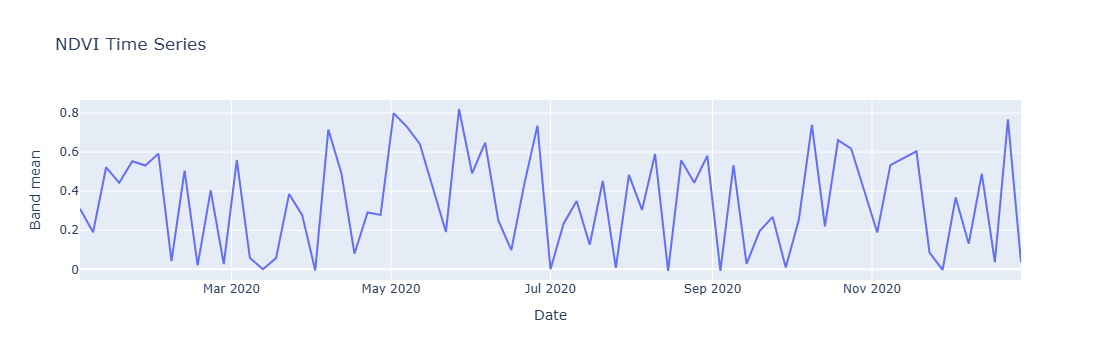

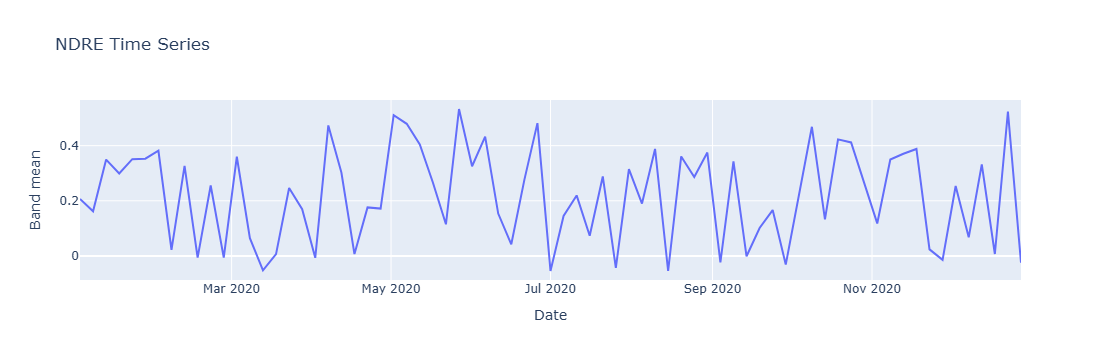

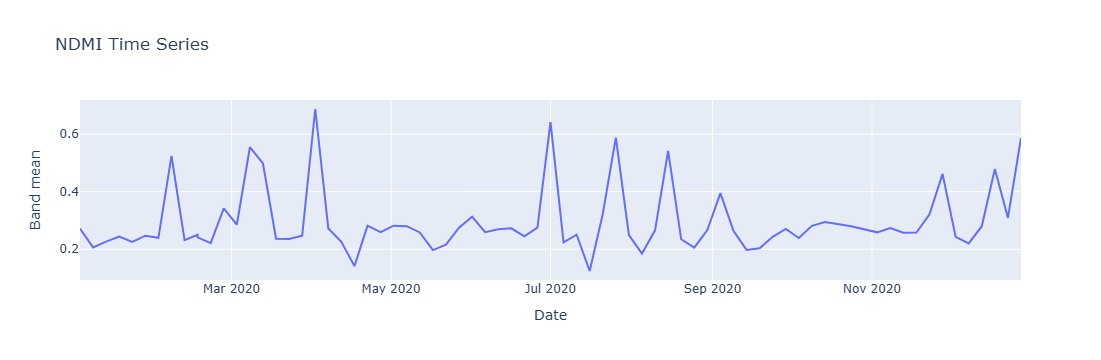

done


In [102]:

fig = px.line(data, x='Date', y='NDVI_mean', title='NDVI Time Series', labels={'NDVI_mean': 'Band mean'})
fig.show()

fig_ndre = px.line(ndre_data, x='Date', y='NDRE_mean', title='NDRE Time Series', labels={'NDRE_mean': 'Band mean'})
fig_ndre.show()

fig_ndmi = px.line(ndmi_data, x='Date', y='NDMI_mean', title='NDMI Time Series', labels={'NDMI_mean': 'Band mean'})
fig_ndmi.show()

# Save to CSV (use a valid local directory path here)
data.to_csv(r"D:\pythonCourse05-04-2024\newNDvi_timeSeries.csv", index=False)
ndre_data.to_csv(r"D:\pythonCourse05-04-2024\newNDRE_timeSeries.csv", index=False)
ndmi_data.to_csv(r"D:\pythonCourse05-04-2024\newNDMI_timeSeries.csv", index=False)
print('done')

### Visualizes elevation, slope, and hillshade of the region by processing DEM data and adding them to the map with appropriate styling.


In [103]:
dataset_dem = ee.Image('USGS/SRTMGL1_003').clip(region)
elevation = dataset_dem.select('elevation').clip(region)
map.addLayer( elevation ,{'palette':['blue','yellow','green'],'min':0 , 'max':100},'elevation')
slope = ee.Terrain.slope(elevation)
map.addLayer(slope, {min:0,max:100}, 'slope')
hillshade =  ee.Terrain.hillshade(elevation).divide(20)
map.addLayer( hillshade ,{'palette':['red','yellow','green'] ,'min':0 , 'max':255},'hillshade')

## output path

In [104]:
elevation_path = r"D:\pythonCourse05-04-2024\Git_Hub\elevation_sample.tif"
slope_path = r"D:\pythonCourse05-04-2024\Git_Hub\slope_sample.tif"
hillshade_path = r"D:\pythonCourse05-04-2024\Git_Hub\hillshade_sample.tif"

## Exports the elevation data 

In [105]:
geemap.ee_export_image(
    elevation,
    filename=elevation_path,
    region=region,
    crs=crs,
    scale=scale,
    file_per_band=file_per_band
)

print('Export completed.')

Generating URL ...
Please wait ...
Data downloaded to D:\pythonCourse05-04-2024\Git_Hub\elevation_sample.tif
Export completed.


## Exports the slope data

In [106]:
geemap.ee_export_image(
        slope,
        filename= slope_path,
        region = region,
        scale = scale,
        file_per_band = file_per_band
)
print('export slope')

Generating URL ...
Please wait ...
Data downloaded to D:\pythonCourse05-04-2024\Git_Hub\slope_sample.tif
export slope


## Exports the hillshade data

In [107]:
geemap.ee_export_image(
        hillshade, 
        filename = hillshade_path,
        region = region,
        scale = scale,
        file_per_band = file_per_band
)
print('export hillshade')

Generating URL ...
Please wait ...
Data downloaded to D:\pythonCourse05-04-2024\Git_Hub\hillshade_sample.tif
export hillshade


##  canopy height

In [108]:
canopy_height_ETH = ee.Image("users/nlang/ETH_GlobalCanopyHeight_2020_10m_v1")
ch = canopy_height_ETH.clip(region)

## Mask out the values that are equal to 255

In [109]:
ch_masked = ch.updateMask(ch.neq(255))

In [110]:
canopy_vis = {
    'min': 0,
    'max': 21,
    'palette': ['red', 'yellow', 'green']}
 
map.addLayer(ch,canopy_vis,'canopy height')


## Cast the image to float32 before exporting

In [111]:
ch_float32 = ch_masked.toFloat()

## Exports the canopy height data 

In [112]:
geemap.ee_export_image(
    ch_float32,
    r"D:\pythonCourse05-04-2024\Git_Hub\elevation_canopy_height_ETH.tif",
    region=region,
    crs='EPSG:4326',
    scale=10
)

Generating URL ...
Please wait ...
Data downloaded to D:\pythonCourse05-04-2024\Git_Hub\elevation_canopy_height_ETH.tif


## precipitation data

In [146]:
dataset = ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY")\
            .filterDate(start_date,end_date)\
            .filterBounds(region)

 sum() provide daily rainfall data

In [147]:
clip_data = dataset.sum().clip(region)
rain = clip_data.select('precipitation')

In [148]:
vis = {
    'min':0,
    'max':30,
     'palette': ['001137', '0aab1e', 'e7eb05', 'ff4a2d', 'e90000']}
map.addLayer(rain , vis , 'Rainfall')

In [149]:
output = r"D:\pythonCourse05-04-2024\Git_Hub\rainfall_sample.tif"

## Exports the precipitation data 

In [150]:
geemap.ee_export_image(
            rain,
        filename = output,
        scale = 5566,
        crs = 'EPSG:4326',
        region = region
        
)

Generating URL ...
Please wait ...
Data downloaded to D:\pythonCourse05-04-2024\Git_Hub\rainfall_sample.tif


## Function to reduce the region and extract precipitation statistics

In [151]:

def reduce_image(image):
    stats = image.reduceRegion(
        reducer=ee.Reducer.min().combine(
            reducer2=ee.Reducer.max(), sharedInputs=True
        ).combine(
            reducer2=ee.Reducer.mean(), sharedInputs=True
        ).combine(
            reducer2=ee.Reducer.stdDev(), sharedInputs=True
        ),
        geometry=region,
        scale=30,
        maxPixels=1e10,
        bestEffort=True
    )
    return image.set({
        'min': stats.get('precipitation_min'),
        'max': stats.get('precipitation_max'),
        'mean': stats.get('precipitation_mean'),
        'stdDev': stats.get('precipitation_stdDev'),
        'system:time_start': image.get('system:time_start')
    })

 ## Map the function over the collection

In [152]:
stats = dataset.map(reduce_image).filter(ee.Filter.neq('mean', None))

## Get the list of dates and values

In [153]:
dates = stats.aggregate_array('system:time_start').getInfo()
min_values = stats.aggregate_array('min').getInfo()
max_values = stats.aggregate_array('max').getInfo()
mean_values = stats.aggregate_array('mean').getInfo()
std_dev_values = stats.aggregate_array('stdDev').getInfo()

### Converts timestamps to datetime format and creates a DataFrame with precipitation statistics (min, max, mean, and standard deviation) for each date.


In [154]:
# Convert timestamps to datetime
dates = [datetime.datetime.utcfromtimestamp(d / 1000) for d in dates]
# ee_date = ee.Date('2020-01-01')
# py_date = datetime.datetime.utcfromtimestamp(ee_date.getInfo()['value']/1000.0)

# # Create a DataFrame
# data = pd.DataFrame({'Date': dates, 'Precipitation (mm)': values})

# Create a DataFrame
data = pd.DataFrame({
    'Date': dates,
    'Min Precipitation (mm)': min_values,
    'Max Precipitation (mm)': max_values,
    'Mean Precipitation (mm)': mean_values,
    'Standard Deviation (mm)': std_dev_values
})


## Create a Plotly figure

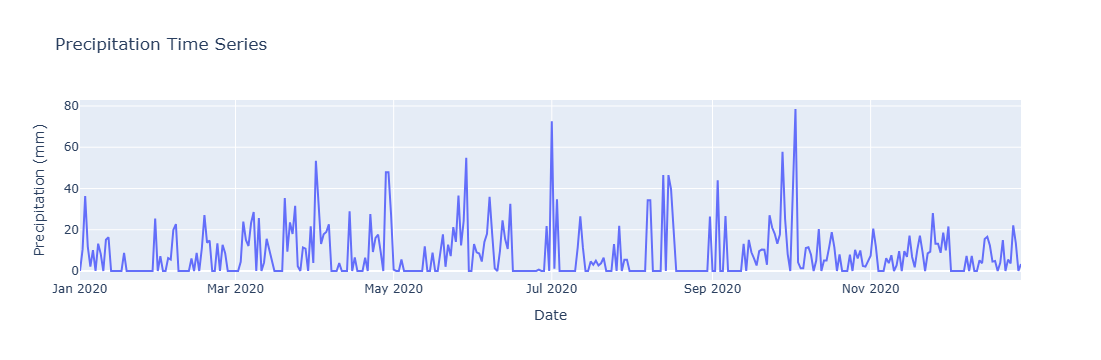

In [157]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data['Date'], y=data['Mean Precipitation (mm)'], mode='lines', name='Mean Precipitation (mm)'))

fig.update_layout(
    title='Precipitation Time Series',
    xaxis_title='Date',
    yaxis_title='Precipitation (mm)',
    # template='plotly_dark'
)


# Update layout with download link
download_csv_link = '''
<a download="precipitation_time_series.csv" href="data:text/csv;charset=utf-8,{csv}" 
style="margin-top:10px;display:block;text-align:center;">Download CSV</a>
'''.format(csv=data.to_csv(index=False, encoding='utf-8').replace('\n', '%0A').replace(',', '%2C'))

# # Display the download link and show the plot
display(HTML(download_csv_link))
fig.show()

## Temperature data

In [160]:
dataset = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY_BY_HOUR")\
            .filterBounds(region)\
            .filterDate(start_date , end_date)
char = dataset.mean().clip(region)
band_temp = char.select('temperature_2m')
visualization = {
#   bands: ['temperature_2m'],
  'min': 250.0,
  'max': 320.0,
  'palette': [
    '000080', '0000d9', '4000ff', '8000ff', '0080ff', '00ffff',
    '00ff80', '80ff00', 'daff00', 'ffff00', 'fff500', 'ffda00',
    'ffb000', 'ffa400', 'ff4f00', 'ff2500', 'ff0a00', 'ff00ff',
  ]
}

## Exports the temperature data

In [161]:
output = r"D:\pythonCourse05-04-2024\Git_Hub\temperature_sample.tif"
geemap.ee_export_image(
        band_temp,
        filename = output,
        crs = 'EPSG:4326',
        scale = 11132 ,
        region = region,
        file_per_band = False
            
)
print('done')

Generating URL ...
Please wait ...
Data downloaded to D:\pythonCourse05-04-2024\Git_Hub\temperature_sample.tif
done


## Function to calculate monthly statistics

In [162]:
def monthly_temperature_stats(month):
    date = ee.Date.fromYMD(2020, month, 1)
    monthly_data = dataset.filterDate(date, date.advance(1, 'month')).select('temperature_2m')
    
    # Calculate mean, max, and min
    mean_temp = monthly_data.mean().reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=region,
        scale=1000
    ).get('temperature_2m')
    
    max_temp = monthly_data.max().reduceRegion(
        reducer=ee.Reducer.max(),
        geometry=region,
        scale=1000
    ).get('temperature_2m')
    
    min_temp = monthly_data.min().reduceRegion(
        reducer=ee.Reducer.min(),
        geometry=region,
        scale=1000
    ).get('temperature_2m')
    
    return ee.Feature(None, {
        'date': date.format('YYYY-MM'),
        'mean_temp': mean_temp,
        'max_temp': max_temp,
        'min_temp': min_temp
    })

# Map over months and create a feature collection
months = ee.List.sequence(1, 12)
temp_features = ee.FeatureCollection(months.map(monthly_temperature_stats))

# Convert to a list of dictionaries to create a DataFrame
temp_dict = temp_features.getInfo()['features']
dates = [item['properties']['date'] for item in temp_dict]
mean_temps = [item['properties']['mean_temp'] for item in temp_dict]
max_temps = [item['properties']['max_temp'] for item in temp_dict]
min_temps = [item['properties']['min_temp'] for item in temp_dict]

# Create a DataFrame
data = pd.DataFrame({
    'Date': dates,
    'Mean Temperature (K)': mean_temps,
    'Max Temperature (K)': max_temps,
    'Min Temperature (K)': min_temps
})

# Convert the 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Save to CSV
output_csv = r"D:\pythonCourse05-04-2024\Git_Hub\temp.csv"
data.to_csv(output_csv, index=False)
print(f'Data saved to {output_csv}')



Data saved to D:\pythonCourse05-04-2024\Git_Hub\temp.csv


## Plot the temperature data using Plotly

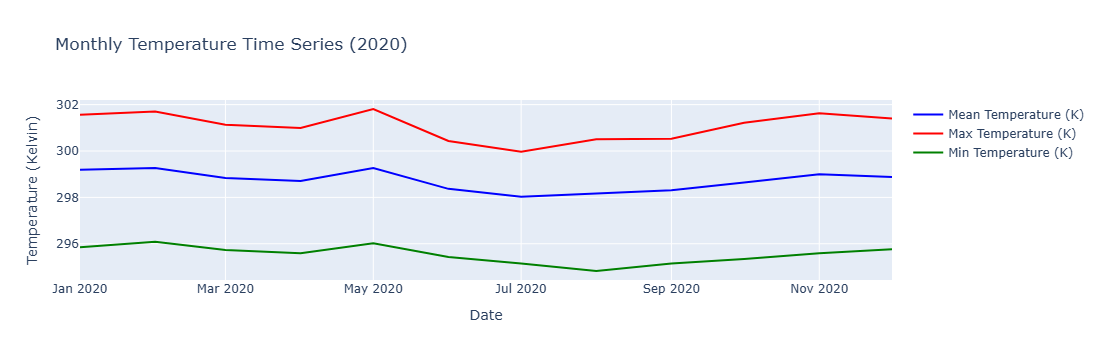

In [163]:
fig = go.Figure()

# Add traces for Mean, Max, and Min Temperature
fig.add_trace(go.Scatter(x=data['Date'], y=data['Mean Temperature (K)'], mode='lines', name='Mean Temperature (K)', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=data['Date'], y=data['Max Temperature (K)'], mode='lines', name='Max Temperature (K)', line=dict(color='red')))
fig.add_trace(go.Scatter(x=data['Date'], y=data['Min Temperature (K)'], mode='lines', name='Min Temperature (K)', line=dict(color='green')))

# Update layout
fig.update_layout(
    title='Monthly Temperature Time Series (2020)',
    xaxis_title='Date',
    yaxis_title='Temperature (Kelvin)'
    # template='plotly_dark'
)

# Show the plot
fig.show()

# Optional: Include the download link for CSV
download_csv_link = '''
<a download="temperature_time_series.csv" href="data:text/csv;charset=utf-8,{csv}" 
style="margin-top:10px;display:block;text-align:center;">Download CSV</a>
'''.format(csv=data.to_csv(index=False, encoding='utf-8').replace('\n', '%0A').replace(',', '%2C'))

display(HTML(download_csv_link))
